In [39]:
import sys
sys.path.append("C:/Users/bene9/PycharmProjects/SOM_22_Coding_Topic_G_Demo_DataCombo-3/venv2/Lib/site-packages/PySOMVis")
from PySOMVis.pysomvis import PySOMVis
from PySOMVis.minisom import MiniSom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import holoviews as hv

# First Tests

Training the SOM...


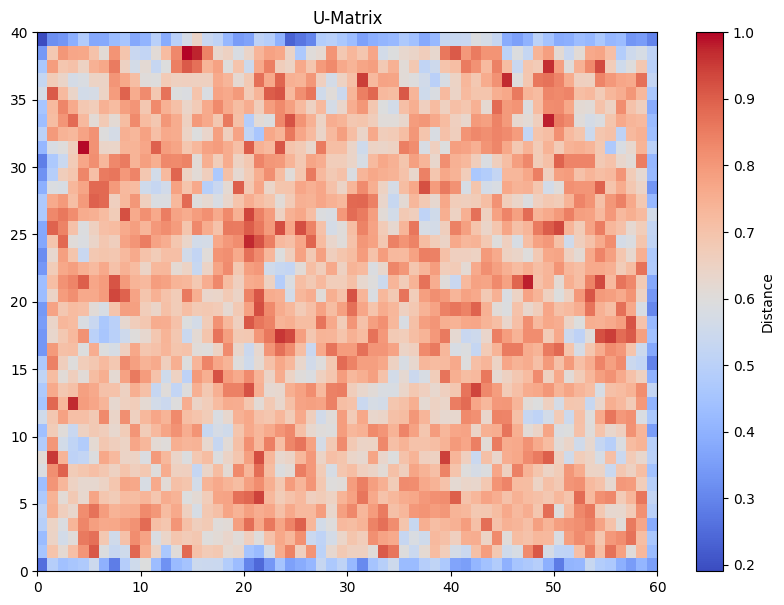

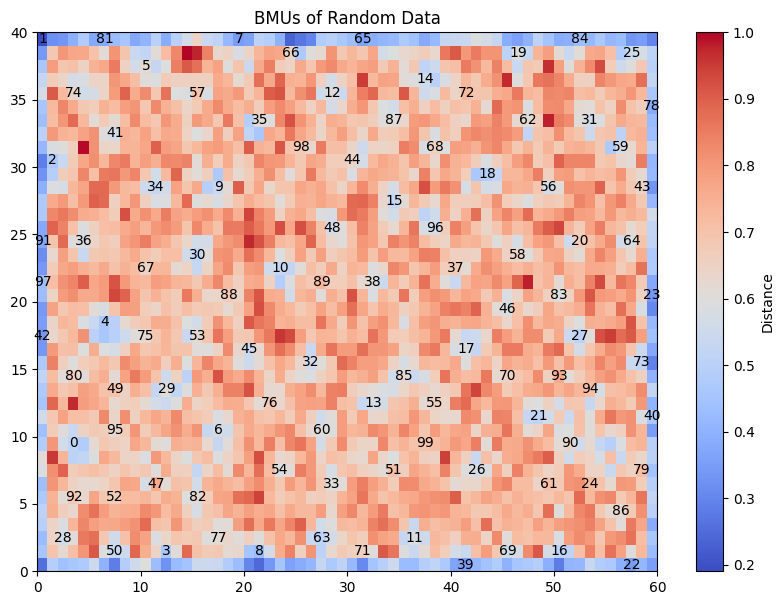

MiniSom test with random dataset completed.


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a random dataset
np.random.seed(42)  # Set seed for reproducibility
data = np.random.rand(100, 10)  # 100 samples, each with 10 features

# Initialize the SOM
som = MiniSom(x=60, y=40, input_len=data.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(data)

# Train the SOM
print("Training the SOM...")
som.train(data, num_iteration=500)  # 500 iterations

# Visualize the U-Matrix
plt.figure(figsize=(10, 7))
plt.title("U-Matrix")
plt.pcolor(som.distance_map().T, cmap="coolwarm")
plt.colorbar(label="Distance")
plt.show()

# Visualize BMUs (Best Matching Units)
plt.figure(figsize=(10, 7))
plt.title("BMUs of Random Data")
plt.pcolor(som.distance_map().T, cmap="coolwarm")
plt.colorbar(label="Distance")

# Plot each data point on the SOM
for i, sample in enumerate(data):
    winner = som.winner(sample)  # Get BMU for the sample
    plt.text(winner[0] + 0.5, winner[1] + 0.5, str(i), color="black", ha="center", va="center")

plt.show()

print("MiniSom test with random dataset completed.")

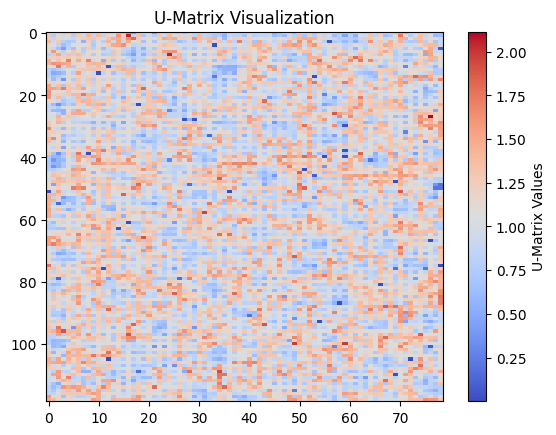

In [11]:
import matplotlib.pyplot as plt
a = PySOMVis(weights=som.get_weights(), input_data=data)
umatrix = a._visualizations[2]
umatrix_data = umatrix.calculate_UMatrix(a._weights, a._m, a._n, a._dim)
plt.imshow(umatrix_data, cmap='coolwarm', aspect='auto')
plt.colorbar(label='U-Matrix Values')
plt.title('U-Matrix Visualization')
plt.show()

# Data Exploration

In [16]:
# Load the dataset
data = pd.read_csv("datasets/Occupancy_Estimation.csv")

# Inspect the dataset
print(data.info())  # Display columns and types
print(data.head())  # Display first few rows

# Identify target, time and features
target = data["Room_Occupancy_Count"]
time = data[["Date", "Time"]]
features = data.drop(columns=["Room_Occupancy_Count", "Date", "Time"])

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled = pd.DataFrame(features_scaled, columns=features.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10129 non-null  object 
 1   Time                  10129 non-null  object 
 2   S1_Temp               10129 non-null  float64
 3   S2_Temp               10129 non-null  float64
 4   S3_Temp               10129 non-null  float64
 5   S4_Temp               10129 non-null  float64
 6   S1_Light              10129 non-null  int64  
 7   S2_Light              10129 non-null  int64  
 8   S3_Light              10129 non-null  int64  
 9   S4_Light              10129 non-null  int64  
 10  S1_Sound              10129 non-null  float64
 11  S2_Sound              10129 non-null  float64
 12  S3_Sound              10129 non-null  float64
 13  S4_Sound              10129 non-null  float64
 14  S5_CO2                10129 non-null  int64  
 15  S5_CO2_Slope       

In [6]:
# Check for missing values
print("Missing values per column:")
print(data.isnull().sum())

Missing values per column:
Date                    0
Time                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64


In [7]:
# Summarize numerical features
print("Numerical feature summary:")
print(features.describe())

Numerical feature summary:
            S1_Temp       S2_Temp       S3_Temp       S4_Temp      S1_Light  \
count  10129.000000  10129.000000  10129.000000  10129.000000  10129.000000   
mean      25.454012     25.546059     25.056621     25.754125     25.445059   
std        0.351351      0.586325      0.427283      0.356434     51.011264   
min       24.940000     24.750000     24.440000     24.940000      0.000000   
25%       25.190000     25.190000     24.690000     25.440000      0.000000   
50%       25.380000     25.380000     24.940000     25.750000      0.000000   
75%       25.630000     25.630000     25.380000     26.000000     12.000000   
max       26.380000     29.000000     26.190000     26.560000    165.000000   

          S2_Light      S3_Light      S4_Light      S1_Sound      S2_Sound  \
count  10129.00000  10129.000000  10129.000000  10129.000000  10129.000000   
mean      26.01629     34.248494     13.220259      0.168178      0.120066   
std       67.30417     58.4

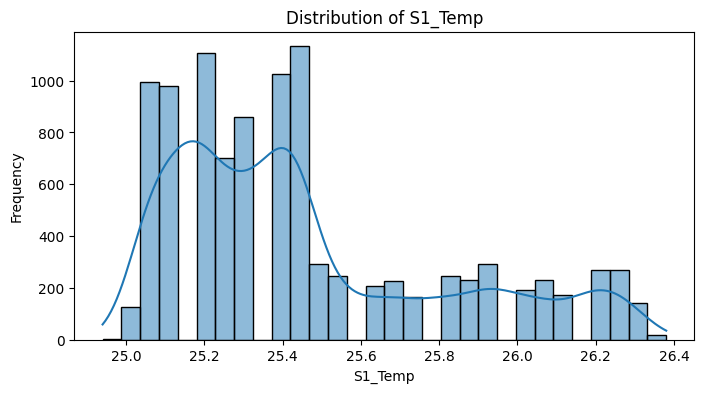

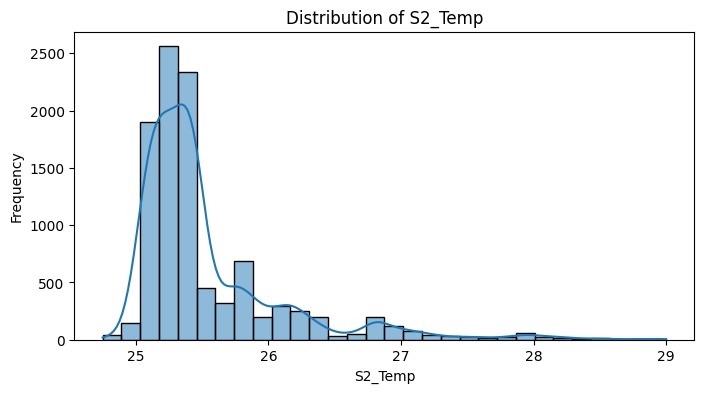

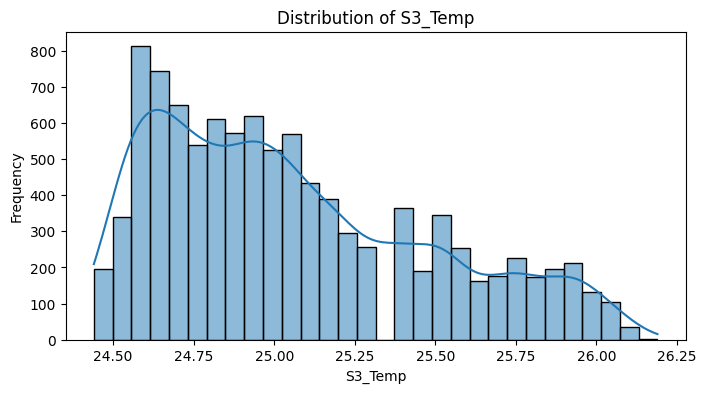

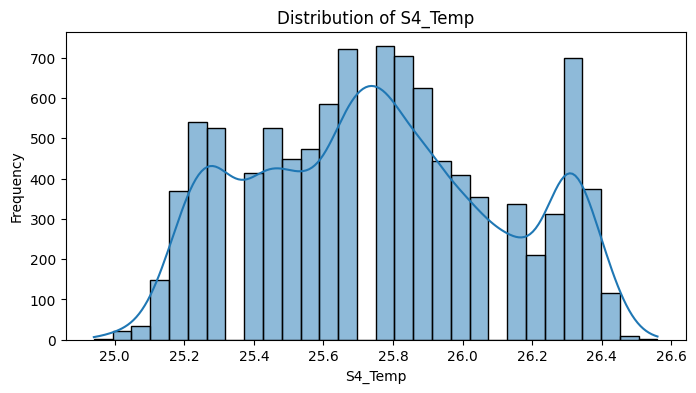

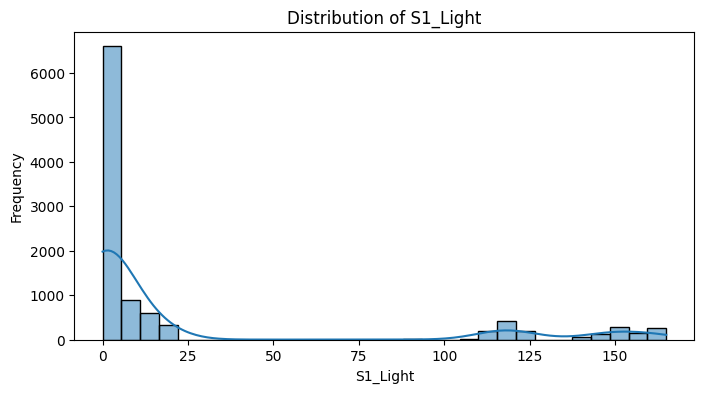

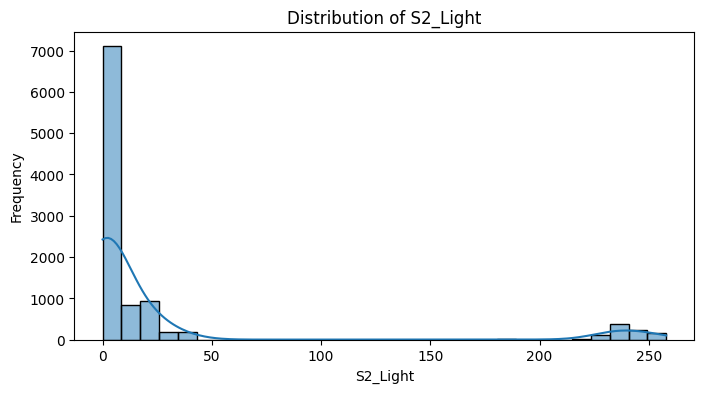

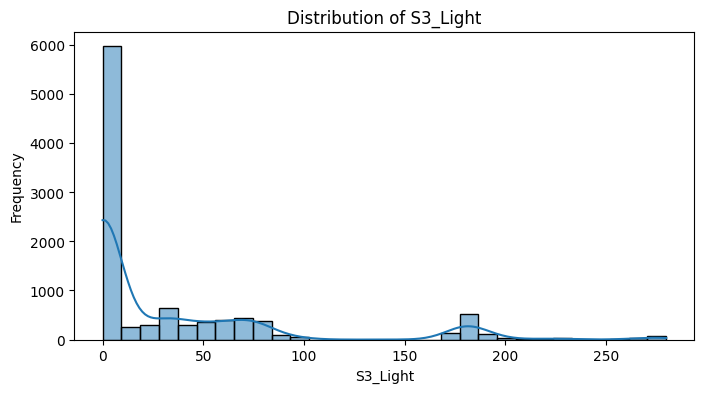

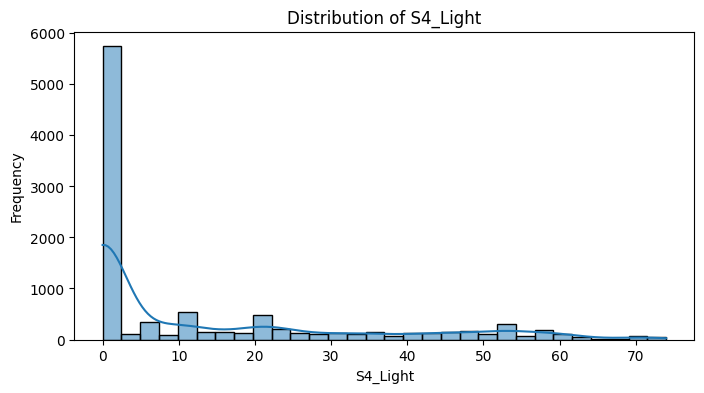

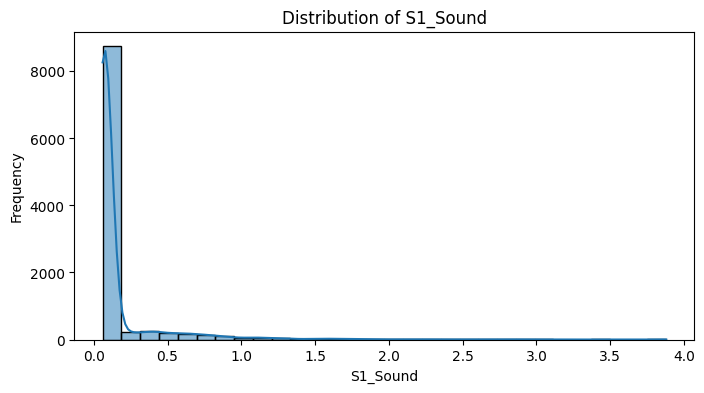

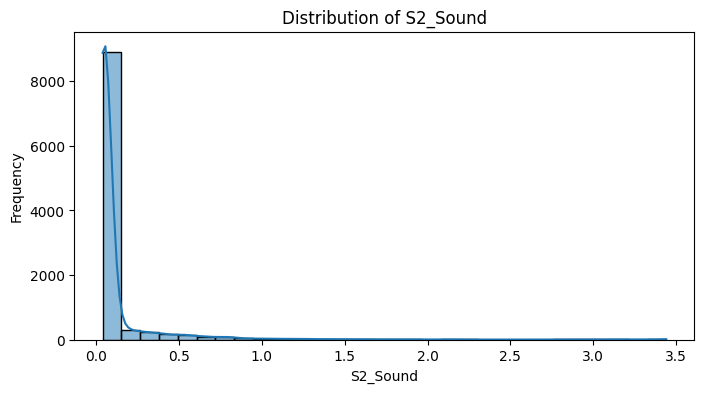

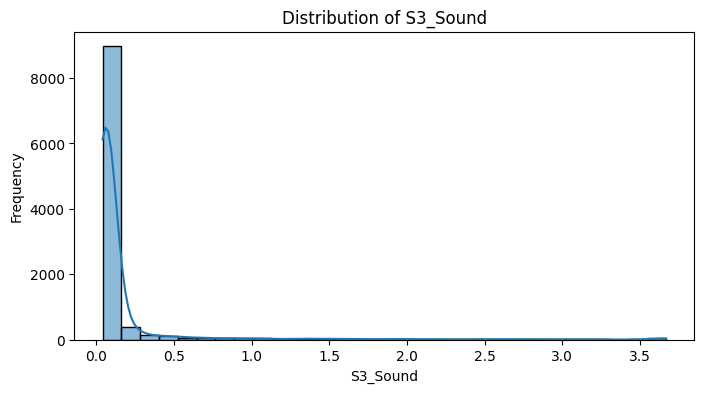

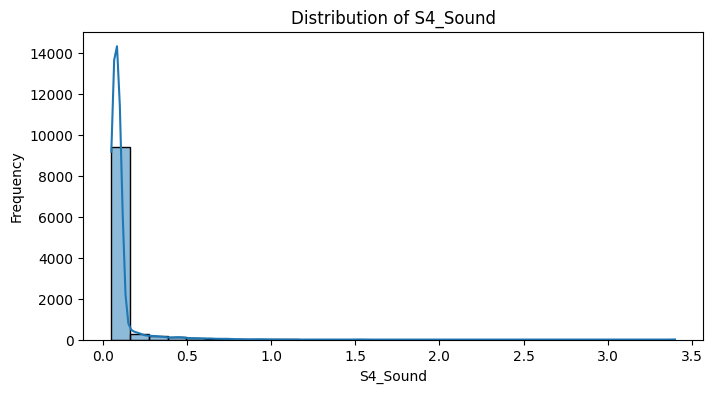

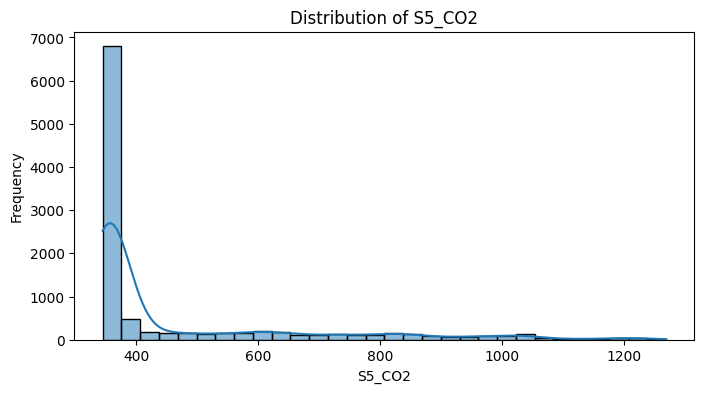

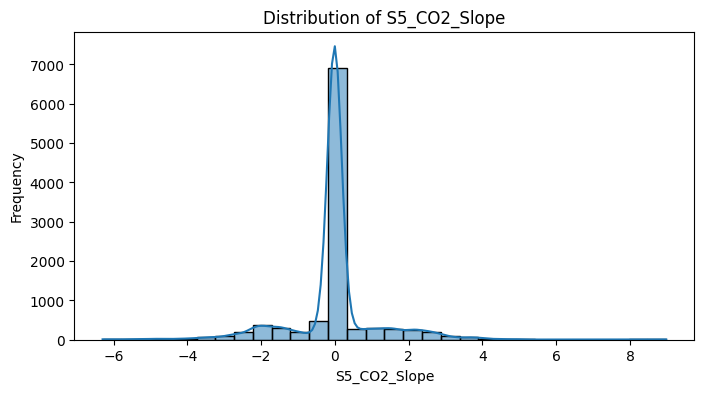

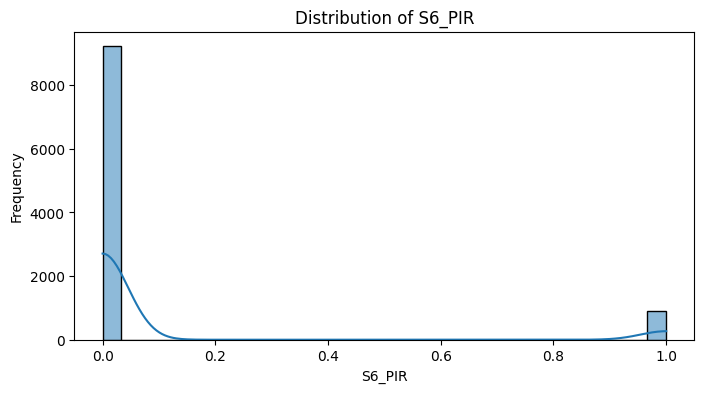

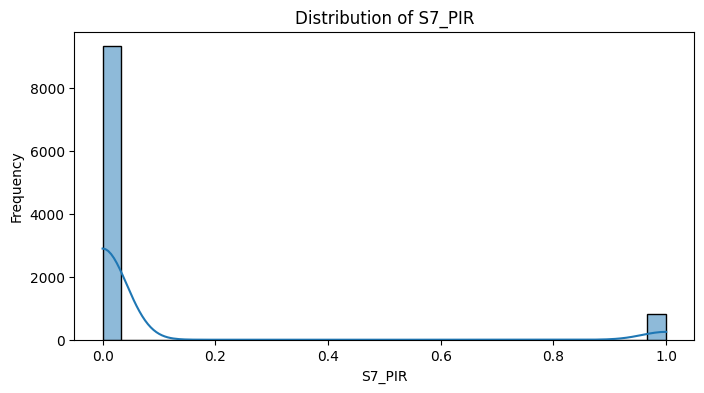

In [19]:
# Visualize distributions of each feature
for column in features.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(features[column], kde=True, bins=30)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

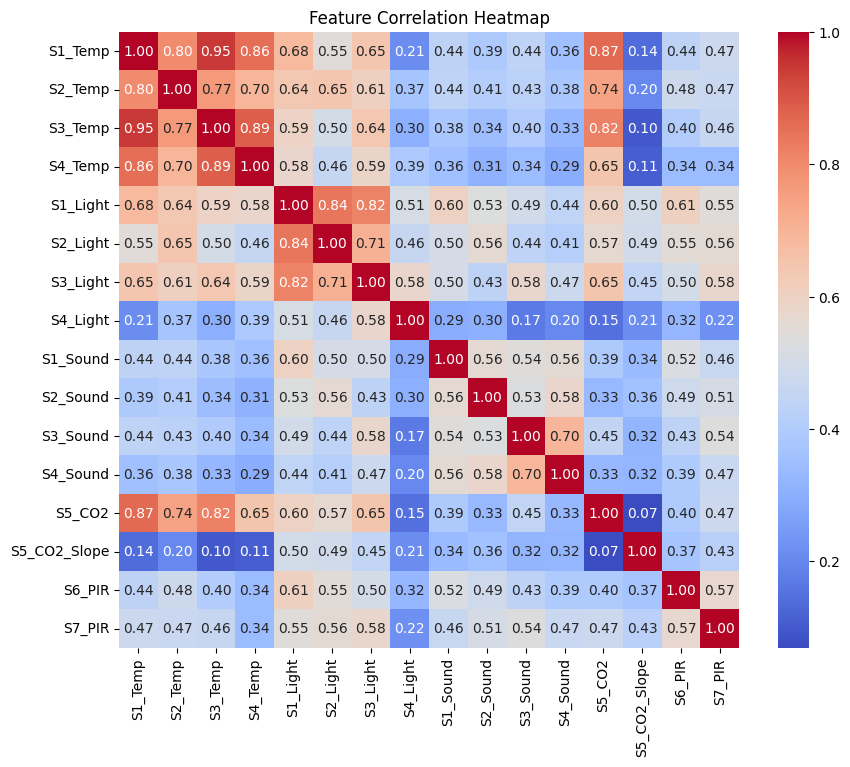

In [9]:
# Check correlations between numerical features
correlation_matrix = features.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [27]:
# Identify features to drop
threshold = 0.85
to_drop = set()
for i in correlation_matrix.columns:
    if i not in to_drop:
        for j in correlation_matrix.columns:
            if i != j and abs(correlation_matrix.loc[i, j]) > threshold and j not in to_drop:
                to_drop.add(j)

# Drop the redundant features
features_scaled_reduced = features_scaled.drop(columns=list(to_drop))
features_reduced = features.drop(columns=list(to_drop))
print(to_drop)

{'S4_Temp', 'S3_Temp', 'S5_CO2'}


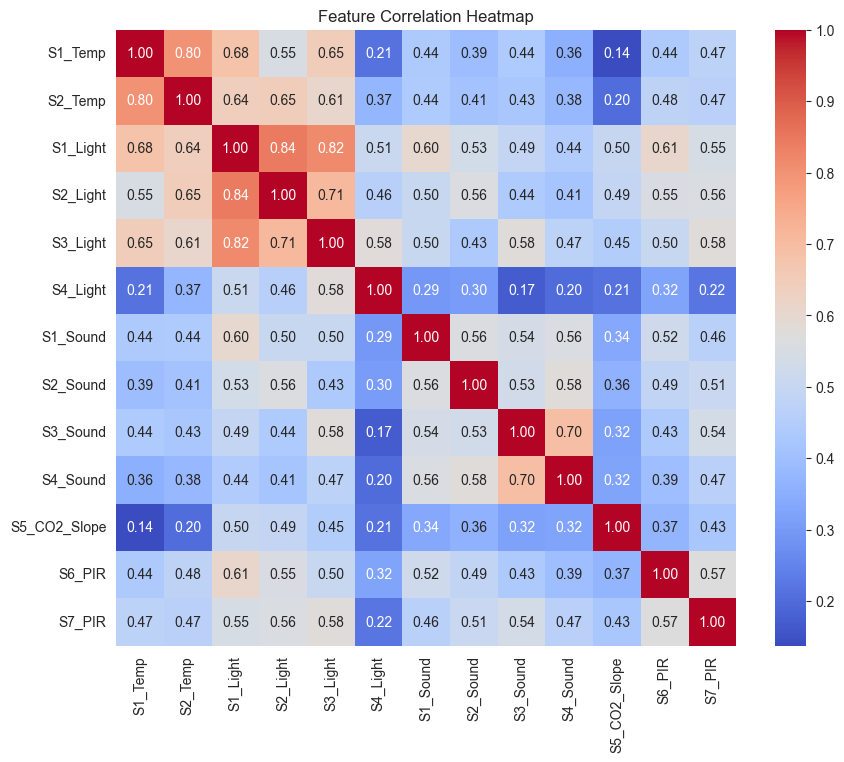

In [28]:
corr_matrix_reduced = features_reduced.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_reduced, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# SOM

In [30]:
# Train the SOM
som = MiniSom(x=60, y=40, input_len=features_scaled_reduced.shape[1], sigma=1.0, learning_rate=0.5)
som.train(features_scaled_reduced.values, num_iteration=1000)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
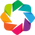

Column
    [0] Column
        [0] Column
            [0] Row(margin=(5, 10), width=700)
                [0] StaticText(value='<b></b>')
                [1] Select(options=OrderedDict([('Component P...]), value=0)
                [2] Select(options=OrderedDict([('PiYG', ...]), value='jet')
                [3] Button(name='↶')
                [4] Button(name='↷')
                [5] Button(name='↔')
                [6] Button(name='↕')
                [7] Checkbox(name='interpolation')
        [1] Row
            [0] Column
                [0] HoloViews(DynamicMap, height=500, sizing_mode='fixed', width=500)
            [1] Row
                [0] Column
                    [0] Column(margin=(5, 10), name='Component Planes')
                        [0] StaticText(value='<b>Component Planes</b>')
                        [1] IntSlider(end=12, name='Component')
                    [1] Str(str)
    [1] Column
        [0] Row()

In [41]:
hv.extension('bokeh')
som_vis = PySOMVis(weights=som.get_weights(), input_data=features_scaled_reduced.values)
som_vis._mainview